## Import data

In [1]:
import re
import json
import torch
import unicodedata
import numpy as np
import pandas as pd
import torch.nn as nn
import tqdm.notebook as tq
from torch.optim import AdamW
import matplotlib.pyplot as plt
from collections import defaultdict
from utils.preprocessing import preprocessing
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
data = pd.read_excel("../data/labeled/intent/combined_intents.xlsx").fillna(0)

In [3]:
data.head(5)

,text,view_menu,view_cart,add_to_cart,remove_from_cart,modify_cart_item,confirm_order,track_order,cancel_order,provide_info
0,"hai pizza double cheese burger cỡ nhỏ, không t...",0,0,1,0,0,0,0,0,0
1,"thèm thêm một chiếc pizza BBQ chicken nữa, nhớ đó",0,0,1,0,0,0,0,0,0
2,"Làm thêm một pizza Margherita, size vừa, crust...",0,0,1,0,0,0,0,0,0
3,"gọi pizza Meat Lovers, cỡ nhỏ, thêm nấm rơm và...",0,0,1,0,0,0,0,0,0
4,"đặt một pizza giống như lần trước, cảm ơn nhé",0,0,1,0,0,0,0,0,0


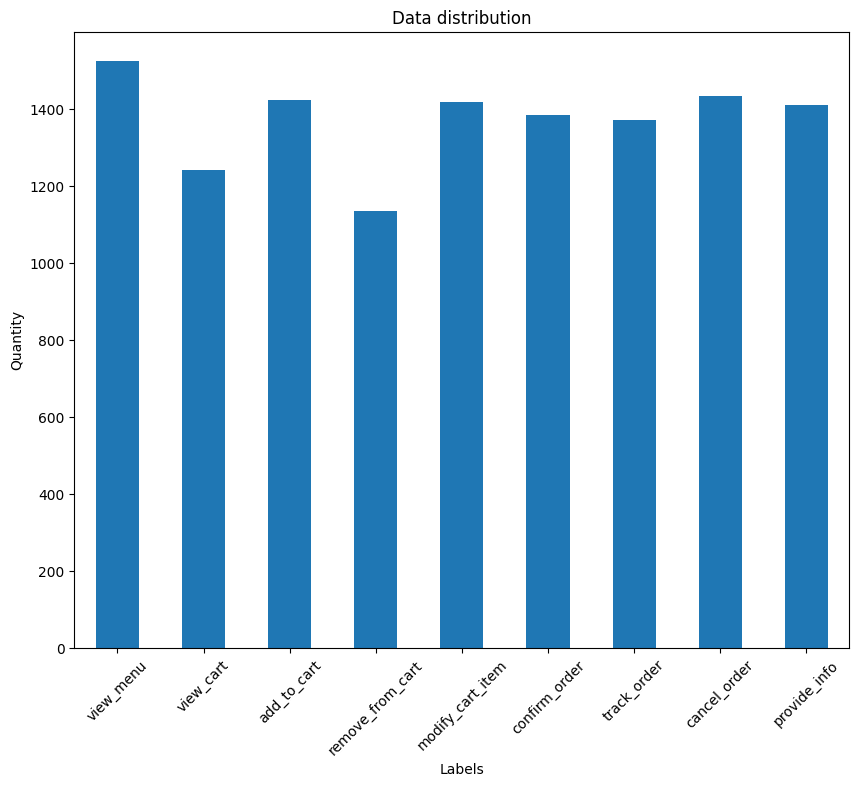

In [4]:
label_counts = data.drop(columns=['text']).sum()

plt.figure(figsize=(10, 8))
label_counts.plot(kind='bar')
plt.title('Data distribution')
plt.xlabel('Labels')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.show()

In [5]:
data["text_clean"] = data["text"].apply(preprocessing)

## Config PhoBERT

#### Set training stats

In [6]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TRAIN_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5

#### Using PhoBERT tokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

#### Implement data format converter

In [8]:
class IntentsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text_clean'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

#### Define PhoBERT model

In [9]:
class PhoBertIntentsRecognition(nn.Module):
    def __init__(self):
        super(PhoBertIntentsRecognition, self).__init__()
        self.phobert = AutoModel.from_pretrained("vinai/phobert-base")
        self.dropout = torch.nn.Dropout(p=0.3)
        self.linear = nn.Linear(768, 9)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.phobert(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [10]:
model = PhoBertIntentsRecognition()
model.to(device)

PhoBertIntentsRecognition(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Layer

#### Define optimizer

In [11]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = AdamW(model.parameters(), lr=1e-5)

#### Define training function

In [12]:
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    return model, float(correct_predictions)/num_samples, np.mean(losses)

#### Define evaluating function

In [13]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size

    return float(correct_predictions)/num_samples, np.mean(losses)

In [14]:
data_train, data_test = train_test_split(data, random_state=77, test_size=0.2, shuffle=True)
data_test, data_valid = train_test_split(data_test, random_state=77, test_size=0.5, shuffle=True)
print(f"Train: {data_train.shape}, Train: {data_test.shape}, Valid: {data_valid.shape}")

Train: (9856, 11), Train: (1232, 11), Valid: (1232, 11)


#### Get labels list

In [15]:
data_target_list = list(data.columns)
data_target_list

['text',
 'view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info',
 'text_clean']

In [16]:
data_target_list = data_target_list[1:10]
data_target_list

['view_menu',
 'view_cart',
 'add_to_cart',
 'remove_from_cart',
 'modify_cart_item',
 'confirm_order',
 'track_order',
 'cancel_order',
 'provide_info']

#### Convert data format to desired format for PhoBERT

In [17]:
train_dataset = IntentsDataset(data_train, tokenizer, MAX_LEN, data_target_list)
valid_dataset = IntentsDataset(data_valid, tokenizer, MAX_LEN, data_target_list)
test_dataset = IntentsDataset(data_test, tokenizer, MAX_LEN, data_target_list)

In [18]:
train_data_loader = DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = DataLoader(test_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

#### Train model

In [19]:
train_history = defaultdict(list)
train_best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    train_history['train_acc'].append(train_acc)
    train_history['train_loss'].append(train_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_loss'].append(val_loss)

    if val_acc > train_best_accuracy:
        torch.save(model.state_dict(), "intents_v2.bin")
        train_best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.2912, val_loss=0.1371 train_acc=0.9066, val_acc=0.9823
Epoch 2/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0974, val_loss=0.0648 train_acc=0.9872, val_acc=0.9899
Epoch 3/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0510, val_loss=0.0410 train_acc=0.9932, val_acc=0.9925
Epoch 4/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0327, val_loss=0.0322 train_acc=0.9953, val_acc=0.9938
Epoch 5/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0237, val_loss=0.0251 train_acc=0.9964, val_acc=0.9951
Epoch 6/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0186, val_loss=0.0300 train_acc=0.9967, val_acc=0.9928
Epoch 7/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0149, val_loss=0.0314 train_acc=0.9975, val_acc=0.9925
Epoch 8/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0130, val_loss=0.0257 train_acc=0.9976, val_acc=0.9936
Epoch 9/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0117, val_loss=0.0266 train_acc=0.9979, val_acc=0.9940
Epoch 10/10


  0%|          | 0/616 [00:00<?, ?it/s]

train_loss=0.0099, val_loss=0.0274 train_acc=0.9982, val_acc=0.9932


##### Training performance

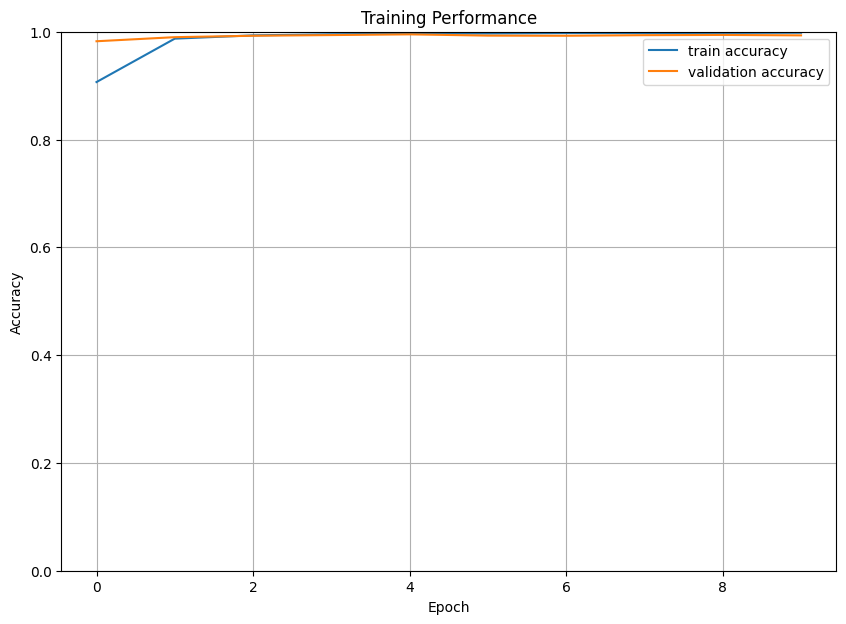

In [22]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(train_history['train_acc'], label='train accuracy')
plt.plot(train_history['val_acc'], label='validation accuracy')
plt.title('Training Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

#### Loss Curve

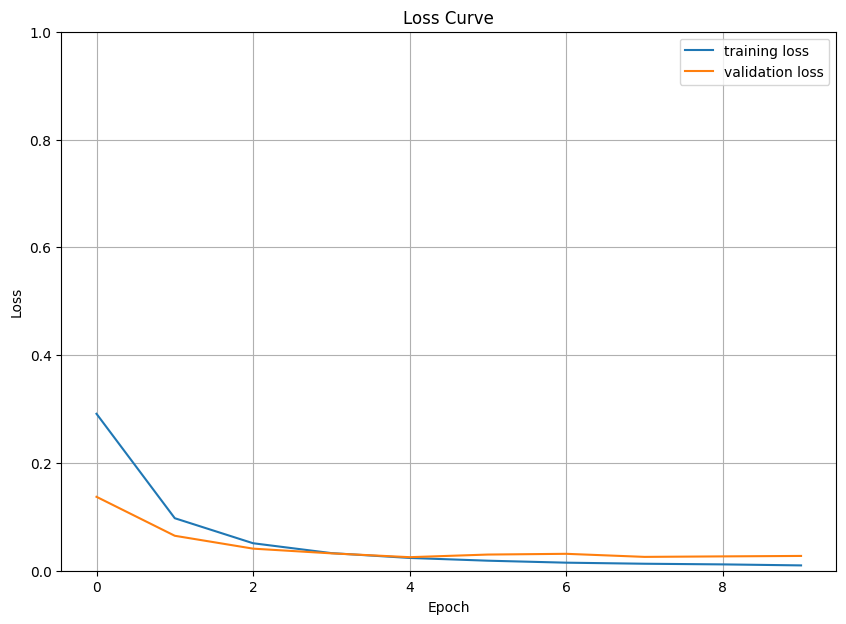

In [24]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(train_history['train_loss'], label='training loss')
plt.plot(train_history['val_loss'], label='validation loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()